In [18]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-04-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(trading_1m.shape)

np.save("data/btc_1m.npy", trading_1m)

(2499840, 6)


In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2499840, 6)


1585699200000.0

In [2]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)
df["hlret"] = np.log(df["high"] / df["low"])
ret_list = []
for i in range(1, 200):
    ret_series = np.abs(np.log(df["close"] / df["close"].shift(i)))
    ret_series.name = f"abs_r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list
df = df[df["abs_r199"].notna()]

del candles
print(df.shape)
df.head()


(2499641, 206)


,date,open,close,high,low,volume,hlret,abs_r1,abs_r2,abs_r3,...,abs_r190,abs_r191,abs_r192,abs_r193,abs_r194,abs_r195,abs_r196,abs_r197,abs_r198,abs_r199
2020-04-01 03:19:00,2020-04-01 03:19:00,6344.14,6340.01,6345.84,6339.63,59.959488,0.000979,0.000651,0.001187,0.002621,...,0.012075,0.012095,0.011522,0.013122,0.012265,0.012164,0.012681,0.012457,0.012647,0.012672
2020-04-01 03:20:00,2020-04-01 03:20:00,6340.00,6342.41,6345.19,6338.89,34.214634,0.000993,0.000378,0.000273,0.000809,...,0.011988,0.011697,0.011717,0.011143,0.012743,0.011887,0.011785,0.012303,0.012078,0.012268
2020-04-01 03:21:00,2020-04-01 03:21:00,6341.93,6344.78,6348.00,6340.47,104.683980,0.001187,0.000374,0.000752,0.000101,...,0.011008,0.011614,0.011323,0.011343,0.010770,0.012370,0.011513,0.011412,0.011929,0.011705
2020-04-01 03:22:00,2020-04-01 03:22:00,6345.48,6345.02,6349.78,6343.54,39.442080,0.000983,0.000038,0.000411,0.000790,...,0.008673,0.010970,0.011577,0.011285,0.011305,0.010732,0.012332,0.011475,0.011374,0.011891
2020-04-01 03:23:00,2020-04-01 03:23:00,6345.07,6349.06,6349.65,6343.79,17.362766,0.000923,0.000637,0.000674,0.001048,...,0.008113,0.008037,0.010334,0.010940,0.010649,0.010669,0.010095,0.011695,0.010839,0.010737


In [3]:
np.load("data/btc_1m.npy")[199:].shape[0] == len(df)

True

所有交点： [-0.2484069061794912, -0.23549493476613023, -0.026180654127043897, -0.004848731963435193, 0.00525725282860818, 0.026490246399058236, 0.1841043877297626, 0.20339056813584222]


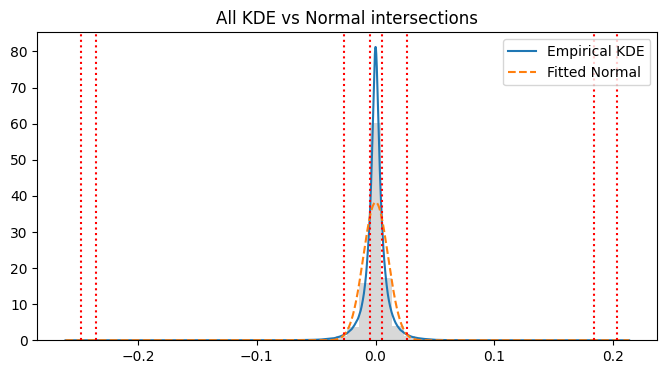

In [4]:
from custom_indicators.utils.plot import find_kde_cross

target = np.log(df["close"] / df["close"].shift(149)).dropna()
roots = find_kde_cross(target)


In [4]:
label = (df["abs_r149"] >= 0.026490246399058236).astype(int)
label.name = "label"
label.sort_index(inplace=True)
label.value_counts()

label
0    2421786
1      77855
Name: count, dtype: int64

In [6]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_threshold_greater_than,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    MIN_LENGTH = 1500

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")[199:]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )
    # sigmoid y_pred
    sigmoid_y_pred = 1 / (1 + np.exp(-y_pred))
    if all(sigmoid_y_pred > 0.5) or all(sigmoid_y_pred < 0.5):
        return 1000

    merged_bar_1 = build_bar_by_threshold_greater_than(
        candles_in_metrics,
        sigmoid_y_pred,
        0.5,
        reverse=False,
    )

    merged_bar_2 = build_bar_by_threshold_less_than(
        candles_in_metrics,
        sigmoid_y_pred,
        0.5,
        reverse=True,
    )

    if len(merged_bar_1) < MIN_LENGTH and len(merged_bar_2) < MIN_LENGTH:
        return 1000
    elif len(merged_bar_1) < MIN_LENGTH:
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return kurtosis_2
    elif len(merged_bar_2) < MIN_LENGTH:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        return kurtosis_1
    else:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return min(kurtosis_1, kurtosis_2)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = ["hlret"] + [f"abs_r{i}" for i in range(1, 200)]

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=8000,
    generations=20,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min", "sqrt", "log"],
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=1,
    parsimony_coefficient=0.005,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

est_gp.fit(df[cols], label)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.69          102.458       11          10.1213              N/A     72.22m
   1    20.10          69.4279       41          8.02433              N/A     70.79m
   2    22.36          64.6721       25          7.19255              N/A     68.69m
   3    32.63          57.6243       24          6.95649              N/A     73.91m
   4    36.20          52.3479       36           5.8042              N/A     69.82m
   5    26.31          67.7633       32          5.64329              N/A     62.29m
   6    26.32           67.954       33          5.64329              N/A     59.59m
   7    27.51           71.244       35          5.40739              N/A     56.53m
   8    28.77           62.103       35          5.40739              N/A  

SymbolicRegressor(feature_names=['hlret', 'abs_r1', 'abs_r2', 'abs_r3',
                                 'abs_r4', 'abs_r5', 'abs_r6', 'abs_r7',
                                 'abs_r8', 'abs_r9', 'abs_r10', 'abs_r11',
                                 'abs_r12', 'abs_r13', 'abs_r14', 'abs_r15',
                                 'abs_r16', 'abs_r17', 'abs_r18', 'abs_r19',
                                 'abs_r20', 'abs_r21', 'abs_r22', 'abs_r23',
                                 'abs_r24', 'abs_r25', 'abs_r26', 'abs_r27',
                                 'abs_r28', 'abs_r29', ...],
                  function_set=['add', 'sub', 'abs', 'neg', 'max', 'min',
                                'sqrt', 'log'],
                  init_method='full', max_samples=1,
                  metric=<gplearn.fitness._Fitness object at 0x38f04d250>,
                  n_jobs=10, p_crossover=0.7, p_hoist_mutation=0.1,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.005, population_size=8000,
                  stopping_criteria=0, tournament_size=50, verbose=1)

In [7]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 9:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res.head(10)


,fitness,len,program
4009,8.998472,71,"sub(neg(sqrt(abs_r63)), max(neg(abs_r20), log(..."
4132,6.682065,91,"sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r1..."
3457,7.074589,91,"sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r1..."
3189,7.680246,91,"sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r1..."
5056,8.600359,91,"sub(neg(abs(sqrt(abs_r63))), max(neg(abs_r20),..."
2012,8.731054,92,"sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r1..."
3669,6.687065,96,"sub(neg(abs(sqrt(abs_r63))), max(max(neg(min(a..."
2514,7.678894,96,"sub(neg(abs(sqrt(abs_r63))), max(max(neg(min(a..."
2042,7.685246,96,"sub(neg(abs(sqrt(abs_r63))), max(max(neg(min(a..."
3133,7.685246,96,"sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r1..."


In [8]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 8.998471818922965: sub(neg(sqrt(abs_r63)), max(neg(abs_r20), log(min(abs_r106, abs_r69))))
fitness = 6.682065398376993: sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r69)))
fitness = 7.074589391306727: sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r45)))
fitness = 7.680245918921045: sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r20)))
fitness = 8.600358739132858: sub(neg(abs(sqrt(abs_r63))), max(neg(abs_r20), log(min(min(abs_r117, abs_r114), abs_r69))))
fitness = 8.731054157444754: sub(neg(sqrt(abs_r63)), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r137)))
fitness = 6.687065398376993: sub(neg(abs(sqrt(abs_r63))), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r69)))
fitness = 7.678894025231139: sub(neg(abs(sqrt(abs_r63))), max(max(neg(min(abs_r15, abs_r137)), log(abs_r176)), log(abs_r15)))
fitness = 7.685245918921045: sub(neg(abs(

In [20]:
"""
sub(neg(sqrt(abs_r63)), max(neg(abs_r20), log(min(abs_r106, abs_r69))))
"""
from math import sqrt

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2025-01-01"),
    helpers.date_to_timestamp("2025-05-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)
df = numpy_candles_to_dataframe(candles)
for i in [10, 23, 42, 176]:
    df[f"abs_r{i}"] = np.abs(np.log(df["close"] / df["close"].shift(i)))


df = df[df["abs_r176"].notna()]
print(df.shape)


def get_gp_res(abs_r10, abs_r23, abs_r42, abs_r176):
    abs_r10 = max(abs_r10, 1e-10)
    abs_r23 = max(abs_r23, 1e-10)
    abs_r42 = max(abs_r42, 1e-10)
    abs_r176 = max(abs_r176, 1e-10)
    try:
        res = sqrt(abs_r10) - abs_r23 - abs_r176
        res = sqrt(max(res, 1e-8))
        res = res - abs_r42
        return res
    except Exception as e:
        print(f"{abs_r10 = }, {abs_r23 = }, {abs_r42 = }, {abs_r176 = }")
        raise e


res_list = []
for abs_r10, abs_r23, abs_r42, abs_r176 in zip(
    df["abs_r10"], df["abs_r23"], df["abs_r42"], df["abs_r176"]
):
    res = get_gp_res(abs_r10, abs_r23, abs_r42, abs_r176)
    res_list.append(res)

df["res"] = res_list

df.head()

(172800, 6)
(172624, 10)


,date,open,close,high,low,volume,abs_r10,abs_r23,abs_r42,abs_r176,res
2025-01-01 02:56:00,2025-01-01 02:56:00,94080.69,94070.37,94083.48,94055.50,4.29494,0.001399,0.003250,0.002878,0.004896,0.168156
2025-01-01 02:57:00,2025-01-01 02:57:00,94070.37,94046.84,94070.37,94046.83,4.11401,0.001149,0.002909,0.003125,0.004207,0.160503
2025-01-01 02:58:00,2025-01-01 02:58:00,94046.83,94074.07,94074.07,94046.83,2.33604,0.001341,0.002875,0.003339,0.003961,0.169241
2025-01-01 02:59:00,2025-01-01 02:59:00,94074.07,94098.91,94098.91,94074.06,2.59270,0.001752,0.003135,0.004227,0.004483,0.180800
2025-01-01 03:00:00,2025-01-01 03:00:00,94098.90,94049.47,94098.91,94049.47,7.50148,0.000870,0.002424,0.003480,0.004137,0.147964


In [21]:
candles.shape[0] - df.shape[0]

176

In [22]:
(df["res"] > 0.5).astype(int).value_counts()

res
0    172624
Name: count, dtype: int64

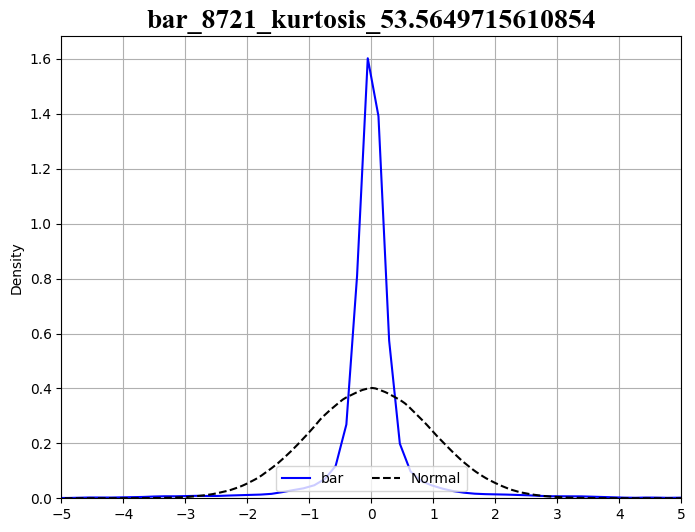

In [18]:
from custom_indicators.utils.plot import plot_kde

merged_bar = build_bar_by_threshold_less_than(
    candles[103:], df["res"].tolist(), 0.5, reverse=False
)

plot_kde(merged_bar[:, 2])